In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.quantum_info import Statevector
import quantum_imaging as qi
import numpy as np
%matplotlib inline

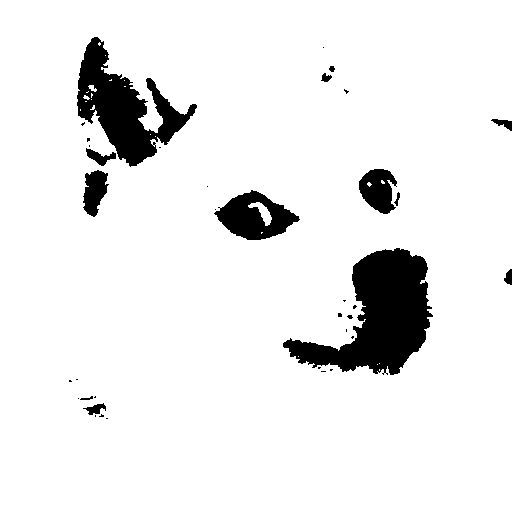

In [2]:
image_doge = qi.convert_to_bw("doge.png") # WoW ! *Much* quantum! *very* doge!
qi.image_from_array(image_doge)

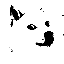

In [3]:
resized_image_doge = qi.resize_array(image_doge, size=(64, 64))
qi.image_from_array(resized_image_doge)

In [4]:
array_binary_doge = qi.binary_encode(resized_image_doge)
qi.save_bin_array_to_csv('doge.csv', array_binary_doge)

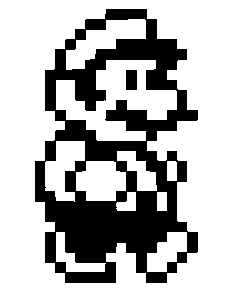

In [5]:
image = qi.convert_to_bw("mario.jpg")
qi.image_from_array(image)

In [6]:
image.shape

(295, 236)

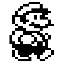

In [7]:
resized_image = qi.resize_array(image, size=(64, 64))
qi.image_from_array(resized_image)

In [8]:
array_binary = qi.binary_encode(resized_image)
qi.save_bin_array_to_csv('mario.csv', array_binary)

In [9]:
#binary_data_array = qi.load_bin_array_from_csv('doge.csv')
binary_data_array = qi.load_bin_array_from_csv('mario.csv')

In [10]:
binary_data_array.shape

(64, 64)

In [11]:
binary_data_array[2]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=uint8)

In [12]:
binary_data_array

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [13]:
binary_data_array.shape

(64, 64)

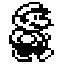

In [14]:
rebuild_data = qi.rebuild_binary_array(binary_data_array)
qi.image_from_array(rebuild_data)

# Use one-hot encoding drawing file to create a Quantum circuit and rebuild the image with the circuit result

# Only support square images (i.e: 32x32px, 64x64px)

In [15]:
n_qubits = 5

cr = ClassicalRegister(n_qubits, "c0")
qr = QuantumRegister(n_qubits, "q0")

base_circuit = QuantumCircuit(qr, cr)

base_circuit.initialize(Statevector.from_label('1'*n_qubits).data, range(n_qubits));

#[base_circuit.initialize([0, 1], i) for i in range(n_qubits)];

In [16]:
# Simulator
qasm_sim = Aer.get_backend("aer_simulator")

In [17]:
row_items = binary_data_array.shape[1]
chunk_split = n_qubits

splitting = int(row_items / chunk_split) + (1 if int(row_items % chunk_split) > 0 else 0)

In [18]:
def create_circuits(n_circuits):
    
    circuits = []

    for i in range(n_circuits):
        circuits.append(base_circuit.copy())
        
    return circuits

def split_str(s):
    
    array = [ch for ch in s]
    
    return array

def rework_result_count(counts):

    result_value = list(counts.keys())
    
    reverse_val = result_value[0][::-1]
    
    return reverse_val
    
def apply_gate(circuit, row):
    
    zeros = np.where(row == 0)
    zeros = zeros[0]

    circuit.barrier()
    
    if np.size(zeros) > 0:
        circuit.x(zeros.tolist())
    else:
        circuit.id(list(range(n_qubits)))
        
    circuit.measure(range(n_qubits), range(n_qubits))
    
    return circuit

final_array = []

for item in binary_data_array:

    row_value = ''
    
    step = 0
        
    circ_copy = create_circuits(splitting)

    for circuit in circ_copy: 

        temp_step = step + chunk_split
        long_step = temp_step
        
        if long_step >= row_items:
            
            long_step = row_items

        chunk = item[step:long_step]
        
        apply_circuit = apply_gate(circuit, chunk)

        sim_counts = execute(circuit, backend=qasm_sim, shots=1).result().get_counts()

        row_value = row_value + rework_result_count(sim_counts)
        
        if temp_step >= row_items:
            
            diff = temp_step - row_items
            
            row_value = row_value[:-diff]

        else:
            
            step = step + chunk_split

    array_row = split_str(row_value)

    final_array.append(array_row)

rework_data = np.array(final_array, dtype='uint8')

In [19]:
rework_data.shape

(64, 64)

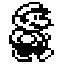

In [20]:
rebuild_data = qi.rebuild_binary_array(rework_data)
qi.image_from_array(rebuild_data)

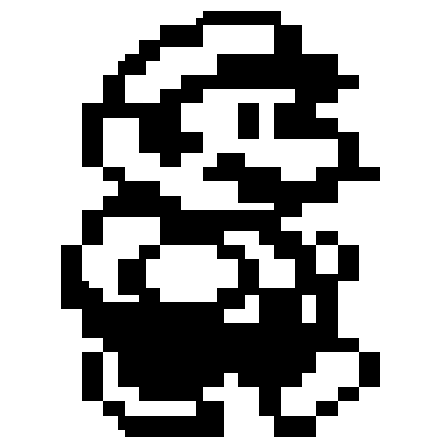

In [21]:
scaled_image = qi.scale_binary_image(rebuild_data, 7)
qi.image_from_array(scaled_image)